In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt;

In /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/djbetts/opt/anaconda3/lib/

In [3]:
from src.ItemItemRecommender import ItemItemRecommender
from sklearn.model_selection import train_test_split

In [4]:
from datetime import datetime

In [110]:
from scipy import sparse
from scipy.sparse import csr_matrix

In [5]:
#Current SQL query
"""
SELECT 
geo__country, 
#geo__city,
event_params__video_title,
event_params__videotitle,
event_name,
#COUNT(event_name) AS times_completed,
FROM `jfp-data-warehouse.production_firebase.firebase_event` 
WHERE geo__country in ('Afghanistan',
 'Algeria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Bhutan',
 'Brunei',
 'China',
 'Egypt',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Japan',
 'Jordan',
 'Kazakstan',
 'Kuwait',
 'Kyrgyzstan',
 'Laos',
 'Libya',
 'Malaysia',
 'Maldives',
 'Mali',
 'Mauritania',
 'Mongolia',
 'Morocco',
 'Myanmar',
 'Nepal',
 'Niger',
 'North Korea',
 'Oman',
 'Pakistan',
 'Palestine',
 'Qatar',
 'Russia',
 'Saudia Arabia',
 'Somalia',
 'Sri Lanka',
 'Sudan',
 'Syria',
 'Tajikistan',
 'Thailand',
 'Timor Leste',
 'Tunisia',
 'Turkey',
 'Turkmenistan',
 'UAE',
 'Uzbekistan',
 'Vietnam',
 'Yemen') AND 
event_params__video_title IS NOT NULL AND
event_name IN ('videostarts',  'videoplay',  'a_media_progress10',  'a_media_progress25',  'a_media_progress50',  'a_media_progress75',  'a_media_progress90') AND 
DATE(event_date_partition) 
BETWEEN  "2021-01-01" AND "2021-04-14" 
GROUP BY 
geo__country, 
geo__city,
event_params__videotitle, 
event_params__video_title,
event_name
ORDER BY 
geo__country,
event_params__video_title
#times_completed DESC 
LIMIT 16000
""";

In [6]:
data = pd.read_csv('/Users/djbetts/Desktop/jf_project/data/recommender_base_top_50.csv')

In [7]:
df = data.copy()
#df.drop(['geo__city', 'times_completed'], axis=1, inplace=True)

In [8]:
df.columns

Index(['geo__country', 'event_params__video_title', 'event_params__videotitle',
       'event_name'],
      dtype='object')

In [9]:
def merge_video(df):
    df['video_title'] = df['event_params__videotitle'].fillna(df['event_params__video_title'])
    df.drop(['event_params__videotitle','event_params__video_title'], axis=1, inplace=True)
    return df

In [10]:
def score(event_name):
    d ={
        'videostarts':.01,
        'videoplay':.01, 
        'a_media_progress10':(1*.1),
        'a_media_progress25':(1*.25),
        'a_media_progress50':(1*.5), 
        'a_media_progress75':(1*.75), 
        'a_media_progress90':(1*.9)
    }
    
    return(d[event_name])

In [11]:
df['video_title'] = df['event_params__videotitle'].fillna(df['event_params__video_title'])

In [12]:
df.drop(['event_params__videotitle','event_params__video_title'], axis=1, inplace=True)

In [13]:
(df.geo__country.value_counts())

India          7243
Egypt          2810
China          2143
Bangladesh     2103
Algeria         621
Afghanistan     390
Bahrain         256
Azerbaijan      233
Bhutan          130
Brunei           71
Name: geo__country, dtype: int64

In [14]:
df.event_name.value_counts()

videoplay             2871
videostarts           2781
a_media_progress10    2408
a_media_progress25    2225
a_media_progress50    2048
a_media_progress75    1891
a_media_progress90    1776
Name: event_name, dtype: int64

<AxesSubplot:>

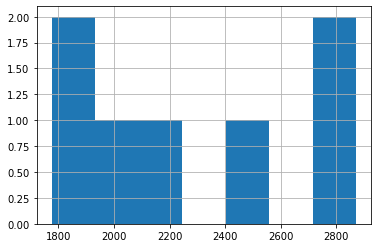

In [15]:
df.event_name.value_counts().hist(bins=7)

In [16]:
df.video_title.value_counts()

Baptism of Jesus by John    1161
Childhood of Jesus          1158
Birth of Jesus              1151
JESUS                        806
Chosen Witness               686
                            ... 
1.우리의 사랑의 추구자이신 예수님            1
JÉSUS                          1
使徒行傳                           1
得救的确据                          1
Witness to the Son             1
Name: video_title, Length: 435, dtype: int64

In [17]:
#df.video_title.hist(bins=435);

# 90% progress through video

In [18]:
#df_90 = df[df['event_name'] == 'a_media_progress90']

In [19]:
#df_90.video_title.unique()

In [20]:
#df_90.geo__country.value_counts()

In [21]:
#country_groupby = df.groupby('geo__country')

In [22]:
#country_groupby['video_title'].unique()

In [23]:
#india = country_groupby.get_group('India')

In [24]:
#falling_plates_india = india[india['video_title'] == '#FallingPlates']

In [25]:
#event_score = falling_plates_india.event_name.value_counts()

In [26]:
#event_score.index

In [27]:
#keys = df.video_title.unique()
#reviews = dict.fromkeys(keys, 0)

In [28]:
#tried to make a function by iterating through a groupby. couldn't figure it out.

# def rating_calculator(group):
#     rating = 0
#     reviews = dict.fromkeys(set(group.video_title), 0)
#     for event_name in group.event_name:
#         if event_name == 'videostarts' or event_name == 'videoplay':
#             reviews[group.video_title] += 1
#         elif event_name == 'a_media_progress10':
#             reviews[group.video_title] += (1 * .1)
#         elif event_name == 'a_media_progress25':
#             reviews[group.video_title] += (1 * .25)
#         elif event_name == 'a_media_progress50':
#             reviews[group.video_title] += (1 * .5)
#         elif event_name == 'a_media_progress75':
#             reviews[group.video_title] += (1 * .75)
#         elif event_name == 'a_media_progress90':
#             reviews[group.video_title] += (1 * .9)
#     print(f'total: {rating}\nnormalized: {rating/len(events)}')
#     return (reviews)
# #     return
# # print(rating)
# # print(rating/len(event_score))

In [29]:
#rating_calculator(event_score)

In [30]:
# #BROKEN
# def review_builder(country_groupby):
#     review_dic = dict.fromkeys(country_groupby.groups.keys(), None)
#     print(review_dic)
#     for country, group in country_groupby:
#         review_dic[country] = rating_calculator(group)
#     return review_dic

# function to return score. not normalized

In [31]:
#view_to_rating('a_media_progress90')

In [32]:
df['score'] = df.event_name.apply(score)

In [33]:
df.drop(['event_name'], axis=1, inplace=True)

<AxesSubplot:>

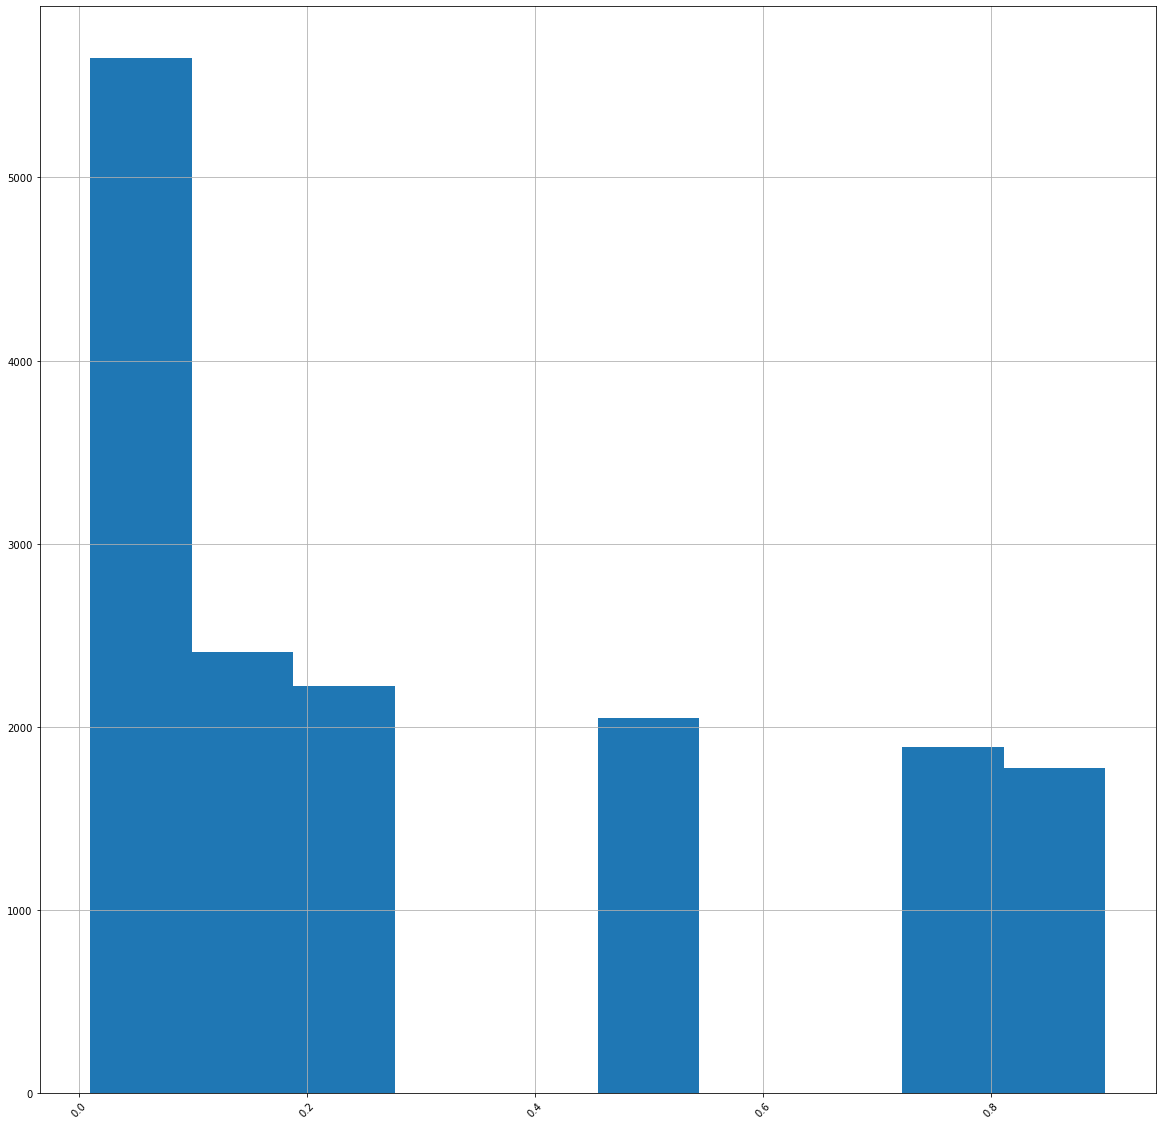

In [34]:
df.score.hist(xrot=45, figsize=(20,20))

In [35]:
groupby = df.groupby(['geo__country','video_title'])

In [36]:
review_scores = groupby.sum()

In [37]:
review_scores.loc[('Bhutan', 'LUMO - John 21:1-25')]

score    0.12
Name: (Bhutan, LUMO - John 21:1-25), dtype: float64

In [38]:
#review_scores.score.plot.bar(figsize=(20,20));

In [39]:
review_scores.loc[('Bhutan','LUMO - John 21:1-25')]

score    0.12
Name: (Bhutan, LUMO - John 21:1-25), dtype: float64

In [40]:
review_scores.unstack()

score                                       \
video_title  #FallingPlates #फालिंगप्लेट्स  #掉落的盘子 1- في العائلة   
geo__country                                                       
Afghanistan            0.02             NaN    NaN           NaN   
Algeria                2.52             NaN    NaN           NaN   
Azerbaijan             2.52             NaN    NaN           NaN   
Bahrain                 NaN             NaN    NaN           NaN   
Bangladesh             5.41             NaN    NaN           NaN   
Bhutan                 0.02             NaN    NaN           NaN   
Brunei                  NaN             NaN    NaN           NaN   
China                  5.04             NaN   7.56           NaN   
Egypt                  5.45             NaN    NaN          0.12   
India                 43.72            0.03    NaN           NaN   

                                                                       \
video_title  1. Jesus, Our Loving Pursuer 1.가족 중에 1.우리의 사랑의 추구자이신 예수님   
geo__country                                                            
Afghanistan                           NaN     NaN                 NaN   
Algeria                               NaN     NaN                 NaN   
Azerbaijan                            NaN     NaN                 NaN   
Bahrain                               NaN     NaN                 NaN   
Bangladesh                           2.52     NaN                 NaN   
Bhutan                                NaN     NaN                 NaN   
Brunei                                NaN     NaN                 NaN   
China                                 NaN     NaN                 NaN   
Egypt                                 NaN     NaN                 NaN   
India                               17.67    0.02                0.01   

                                                          \
video_title  2- عمل يدوي 2. Jesus, Our Gracious Forgiver   
geo__country                                               
Afghanistan          NaN                             NaN   
Algeria              NaN                             NaN   
Azerbaijan           NaN                             NaN   
Bahrain              NaN                             NaN   
Bangladesh           NaN                            1.62   
Bhutan               NaN                             NaN   
Brunei               NaN                             NaN   
China                NaN                             NaN   
Egypt               0.12                            2.69   
India                NaN                            9.18   

                                             ...                            \
video_title  3. Jesus, Our Power for Living  ... 路加福音简介 身份错认于路司得 返回叙利亚的安提阿   
geo__country                                 ...                             
Afghanistan                             NaN  ...    NaN      NaN       NaN   
Algeria                                 NaN  ...    NaN      NaN       NaN   
Azerbaijan                              NaN  ...    NaN      NaN       NaN   
Bahrain                                 NaN  ...    NaN      NaN       NaN   
Bangladesh                              NaN  ...    NaN      NaN       NaN   
Bhutan                                  NaN  ...    NaN      NaN       NaN   
Brunei                                  NaN  ...    NaN      NaN       NaN   
China                                   NaN  ...   2.89     2.52      2.52   
Egypt                                   NaN  ...    NaN      NaN       NaN   
India                                  5.04  ...    NaN      NaN       NaN   

                                                                             
video_title  选出马提亚替代犹大 那些使人犯罪的人有祸了 钉在十字架上的囚犯 雅典的偶像 非斯都咨询亚基帕王 高贵的比里亚人 魔鬼引诱耶稣  
geo__country                                                                 
Afghanistan        NaN         NaN       NaN   NaN       NaN     NaN    NaN  
Algeria            NaN         NaN       NaN   NaN       NaN     NaN    NaN  
A

In [41]:
#review_scores.plot.bar(figsize=(20,20));

In [42]:
review_scores.index

MultiIndex([('Afghanistan',                         '#FallingPlates'),
            ('Afghanistan',                     'Angels at the Tomb'),
            ('Afghanistan',               'Baptism of Jesus by John'),
            ('Afghanistan',                             'Beatitudes'),
            ('Afghanistan',                         'Birth of Jesus'),
            ('Afghanistan',    'Blessed are those Who Hear and Obey'),
            ('Afghanistan',                                'Breathe'),
            ('Afghanistan',                        'Burial of Jesus'),
            ('Afghanistan',                     'Childhood of Jesus'),
            ('Afghanistan',                         'Chosen Witness'),
            ...
            (      'India',                              'Episode 9'),
            (      'India', 'Eutychus Raised From the Dead at Troas'),
            (      'India',        'Explanation of Miraculous Birth'),
            (      'India',                           'Fallin

In [44]:
df_sparce = df.pivot_table(columns='video_title', values='score', index='geo__country', aggfunc='mean', fill_value=0)
movie_list = pd.Series(df_sparce.columns)
users = pd.Series(df_sparce.index)

In [45]:
df_sparce.shape

(10, 435)

In [46]:
number_ratings = (df_sparce.values > 0).sum()
density = number_ratings / (df_sparce.shape[0] * df_sparce.shape[1])
print('The desnsity is: {} '.format(density))

The desnsity is: 0.19057471264367817 


Min number of ratings: 9


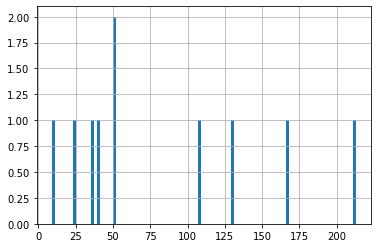

In [47]:
ratings = (df_sparce > 0).sum(axis=1)
ratings.hist(bins=100)
print('Min number of ratings: {}'.format(ratings.min()))

Min number of ratings: 1


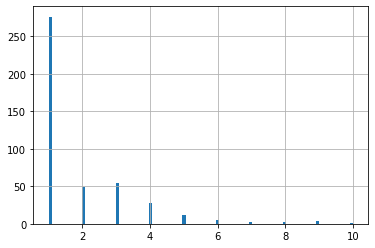

In [48]:
ratings = (df_sparce > 0).sum(axis=0)
ratings.hist(bins=100)
print('Min number of ratings: {}'.format(ratings.min()))

# utility matric

In [49]:
df_sparce.index

Index(['Afghanistan', 'Algeria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Bhutan', 'Brunei', 'China', 'Egypt', 'India'],
      dtype='object', name='geo__country')

In [50]:
train, test = train_test_split(df_sparce.values, random_state = 100)

In [51]:
ratings_as_mat = csr_matrix(df_sparce.values, (df_sparce.index.shape[0], df_sparce.columns.shape[0]))

In [52]:
print(train.shape)
print(test.shape)
print(df_sparce.shape)

(7, 435)
(3, 435)
(10, 435)


In [53]:
ratings_as_mat.shape

(10, 435)

In [54]:
rec = ItemItemRecommender(neighborhood_size=75)
rec.fit(ratings_as_mat)

In [55]:
users

0    Afghanistan
1        Algeria
2     Azerbaijan
3        Bahrain
4     Bangladesh
5         Bhutan
6         Brunei
7          China
8          Egypt
9          India
Name: geo__country, dtype: object

In [56]:
print(users[3])
rec.pred_one_user(user_id=3)

Bahrain


/Users/djbetts/Desktop/jf_project/src/ItemItemRecommender.py:43: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()


array([0.19406524, 0.04      , 0.        , 0.04      , 0.02531806,
       0.04      , 0.04      , 0.04      , 0.05164735, 0.04      ,
       0.04      , 0.        , 0.04      , 0.04      , 0.10069525,
       0.09646734, 0.        , 0.04      , 0.04      , 0.28354756,
       0.04      , 0.04      , 0.04      , 0.20818483, 0.05575517,
       0.18618744, 0.04      , 0.05256406, 0.09733891, 0.25741687,
       0.18319451, 0.04      , 0.27264748, 0.04      , 0.15020326,
       0.04      , 0.04      , 0.32832103, 0.19767748, 0.24234841,
       0.20990314, 0.04      , 0.12162239, 0.19528045, 0.24455143,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.27779905, 0.25869193, 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04   

# top rated movies

In [57]:
average_rating = df.groupby('video_title').mean()['score']

In [58]:
average_rating.sort_values(ascending=False)

video_title
十字架上的标志                                      0.384000
Paul Transferred to Caesarea                 0.384000
耶路撒冷会议                                       0.368462
介绍                                           0.367647
Parable of the Pharisee and Tax Collector    0.363608
                                               ...   
This Is Freedom                              0.010000
JÉSUS                                        0.010000
Waiting on the Alchemist                     0.010000
#फालिंगप्लेट्स                               0.010000
Jesus Gathers Disciples                      0.010000
Name: score, Length: 435, dtype: float64

# utility matrix work

In [59]:
index = df.geo__country.unique()

In [60]:
columns = df.video_title.unique()

In [61]:
data = np.zeros((index.shape[0], columns.shape[0]))

In [62]:
reviews = pd.DataFrame(data, index=index, columns=columns)

In [63]:
reviews

,#FallingPlates,Angels at the Tomb,Baptism of Jesus by John,Beatitudes,Birth of Jesus,Blessed are those Who Hear and Obey,Breathe,Burial of Jesus,Childhood of Jesus,Chosen Witness,...,Division in Corinth,Don&#39;t Hold Your Breath,Doubting Thomas,Dying Roads,Eutychus Raised From the Dead at Troas,Falling Away,"Feeding 5,000",Fellowship Of Believers,Festus Consults King Agrippa,Finishing Well
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Azerbaijan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bahrain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bangladesh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bhutan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brunei,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
China,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Egypt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
df.head()

,geo__country,video_title,score
0,Afghanistan,#FallingPlates,0.01
1,Afghanistan,#FallingPlates,0.01
2,Afghanistan,Angels at the Tomb,0.10
3,Afghanistan,Angels at the Tomb,0.50
4,Afghanistan,Angels at the Tomb,0.01


# geo__city runthrough

In [65]:
#1. import data
#2. convert to score
#5. drop event_name
#3. merge video titles
#4. remove unlabeled city names
#5. groupby user, item and sum
#6. reset index to create list of reviews

#7. create pivot table to visualize sparse matrix df
#8. create user, movie encoder/id system
#9. encode reviews for scipy.sparse.csr_matrix. index MUST be int not str

#10. test, train, split

In [66]:
data = pd.read_csv('/Users/djbetts/Desktop/jf_project/data/recommender_top50_geo__city.csv')

In [67]:
df = data.copy()

In [68]:
df = df[df['geo__city'] != '(not set)']

In [69]:
df = merge_video(df)

In [70]:
df['score'] = df['event_name'].apply(score)

In [71]:
df.drop(['event_name'], axis=1, inplace=True)

In [72]:
groupby = df.groupby(['geo__city', 'video_title'])

In [73]:
reviews = groupby.mean()

In [74]:
reviews.reset_index(inplace=True)

In [75]:
pivot_table = reviews.pivot_table(values='score', index='geo__city', columns='video_title')

In [78]:
cities = pd.Series(pivot_table.index, index=np.arange(1,(len(pivot_table.index)+1)))
#cities['id'] = pd.Series(np.arange(1,(len(cities)+1)))

In [79]:
cities

1                         10th of Ramadan City
2                          6th of October City
3                                        Adoor
4                                     Agartala
5                                         Agra
                        ...                   
375    Xishuangbanna Dai Autonomous Prefecture
376                                   Yavatmal
377                                    Zagazig
378                                  Zhengzhou
379                                  Zhongshan
Name: geo__city, Length: 379, dtype: object

In [80]:
cities_code = {v: k for k, v in cities.items()}

In [81]:
reviews['city_id'] = reviews.geo__city.replace(to_replace=cities_code)

In [82]:
movies = pd.Series(pivot_table.columns, index=np.arange(1,(len(pivot_table.columns)+1)))

In [83]:
movies

1                    #FallingPlates
2                   #फालिंगप्लेट्स 
3                            #掉落的盘子
4                     1- في العائلة
5      1. Jesus, Our Loving Pursuer
                   ...             
363                          路加福音简介
364                     那些使人犯罪的人有祸了
365                       钉在十字架上的囚犯
366                       非斯都咨询亚基帕王
367                          魔鬼引诱耶稣
Name: video_title, Length: 367, dtype: object

In [84]:
#movies['id'] = pd.Series(np.arange(1,(len(movies)+1)))

In [85]:
movies_code = {v: k for k, v in movies.items()}

In [86]:
reviews['movie_id'] = reviews.video_title.replace(to_replace=movies_code)

In [87]:
reviews = reviews[['city_id', 'movie_id', 'score']]

In [88]:
reviews

,city_id,movie_id,score
0,1,30,0.360000
1,1,33,0.360000
2,1,44,0.360000
3,1,145,0.360000
4,1,240,0.173333
...,...,...,...
2634,377,198,0.360000
2635,377,204,0.360000
2636,377,243,0.360000
2637,378,12,0.360000


In [89]:
train, test = train_test_split(reviews, random_state = 100)

In [90]:
# Number of users that are in train and not test
len(np.setdiff1d(test.city_id.unique(), train.city_id.unique()))

26

In [91]:
# Number of movies in train and not test
len(np.setdiff1d(test.movie_id.unique(), train.movie_id.unique()))

39

In [92]:
average_rating = reviews.groupby('movie_id').mean()['score']

In [93]:
movies.loc[average_rating.sort_values().index]

movie_id
217         Rivka Believes
313                  奮鬥與成就
317               彼得向围观者发言
318                  得救的确据
244    The Four Principles
              ...         
275        Women Disciples
289                     介绍
353                 耶路撒冷会议
303                十字架上的标志
117           Falling Away
Name: video_title, Length: 367, dtype: object

In [94]:
ratings_as_mat = csr_matrix((train.score, 
        ((train.city_id), (train.movie_id))))

In [95]:
ratings_as_mat.shape

(380, 368)

In [96]:
rec = ItemItemRecommender(neighborhood_size=75)
rec.fit(ratings_as_mat)

In [97]:
movies.loc[rec.top_n_recs(user_id=1, n=10)]

/Users/djbetts/Desktop/jf_project/src/ItemItemRecommender.py:43: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()


31                              Beatitudes
47                      Cleaning the Lamps
125                               Fracture
42                                Cabernet
119                Fellowship Of Believers
36                        Blind Man Healed
56           Darkness and Jesus&#39; Death
352                                     耶穌
35     Blessed are those Who Hear and Obey
28                  Assurance Of Salvation
Name: video_title, dtype: object

In [98]:
cities

1                         10th of Ramadan City
2                          6th of October City
3                                        Adoor
4                                     Agartala
5                                         Agra
                        ...                   
375    Xishuangbanna Dai Autonomous Prefecture
376                                   Yavatmal
377                                    Zagazig
378                                  Zhengzhou
379                                  Zhongshan
Name: geo__city, Length: 379, dtype: object

# Finally testing!

In [99]:
test.groupby('city_id').count().head(15)

,movie_id,score
city_id,,
1,1,1
2,3,3
3,1,1
5,4,4
6,4,4
9,1,1
10,15,15
11,2,2
13,1,1


In [100]:
cities.loc[10]

'Alexandria'

In [101]:
city_ten = test[test.city_id == 10]

In [102]:
predictions = rec.pred_one_user(user_id=10)

/Users/djbetts/Desktop/jf_project/src/ItemItemRecommender.py:43: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()


In [103]:
city_ten['prediction'] = predictions[test[test.city_id == 10].movie_id.values]
city_ten

/Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,city_id,movie_id,score,prediction
117,10,275,0.3600,0.217825
63,10,45,0.3600,0.215773
65,10,79,0.0100,0.330851
71,10,97,0.0100,0.327574
115,10,262,0.0100,0.236011
85,10,145,0.3600,0.242863
116,10,272,0.1740,0.209180
107,10,217,0.0100,0.000000
75,10,107,0.3600,0.360000
57,10,16,0.0100,0.212327


In [109]:
movies.loc[173]

'Jätku Leiba'

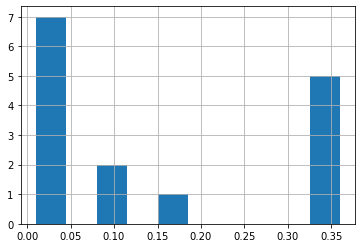

In [105]:
city_ten.score.hist();

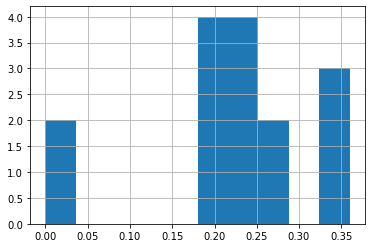

In [106]:
city_ten.prediction.hist();

In [107]:
#import necessary libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(city_ten.score, city_ten.prediction))

0.18291163085994452

In [108]:
movies.loc[rec.top_n_recs(user_id=10, n=10)]

/Users/djbetts/Desktop/jf_project/src/ItemItemRecommender.py:43: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()


107                          Episode 5
2                      #फालिंगप्लेट्स 
69           Day 4: Devil Tempts Jesus
58                   Day 1: Beginnings
65             Day 2: Miraculous Birth
15     6. Jesus, Our Complete Restorer
63             Day 29: Triumphal Entry
52                            Creation
90                     Doubting Thomas
10      3. Jesus, Our Power for Living
Name: video_title, dtype: object